# Классификация знаков Дорожного Движения

In [1]:
# !pip install natsort

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [3]:
data = []
labels = []
sumu =0
start = 0
input_size = (70,70)
path = "./New_Dataset/priority_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if count == 320: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

12 2093
13 2153
14 773
43 245
44 281
45 281
46 245
47 209
all 6280


In [4]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    8
dtype: int64
13    2153
12    2093
14     773
44     281
45     281
43     245
46     245
47     209
Name: labels, dtype: int64


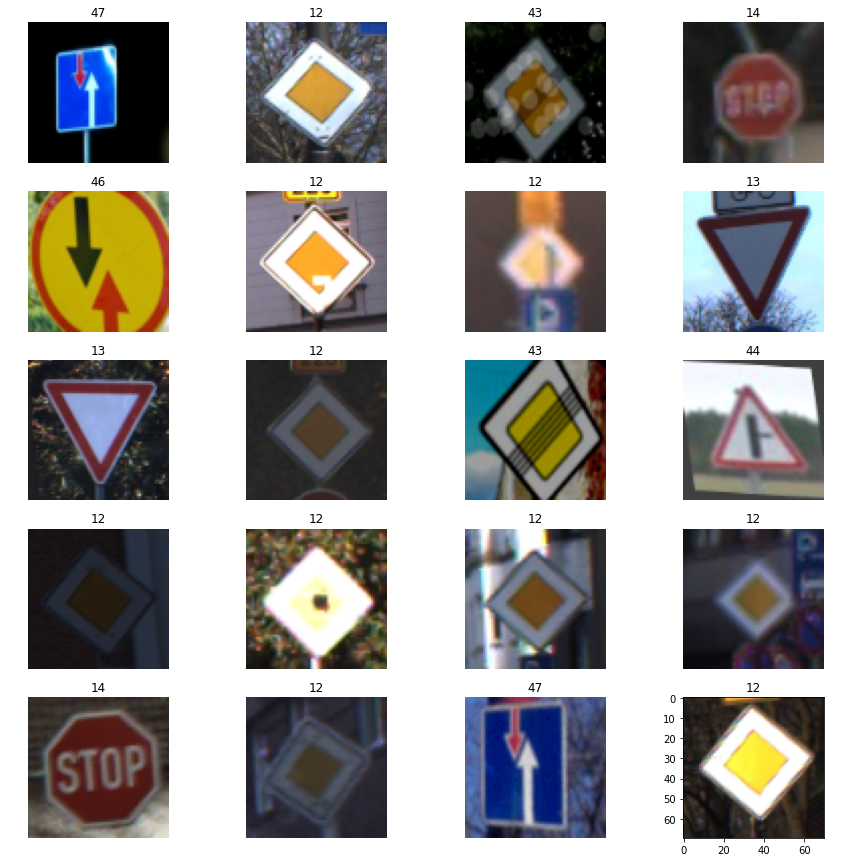

In [5]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD

opt = SGD(learning_rate=0.001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=32, kernel_size=5))
model.add(ReLU())

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=32, kernel_size=5))
model.add(ReLU())

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=32, kernel_size=5))
model.add(ReLU())

model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=64, kernel_size=5))
model.add(ReLU())



model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(32, activation='relu')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 74, 74, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 70, 70, 32)        2432      
                                                                 
 re_lu (ReLU)                (None, 70, 70, 32)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 74, 74, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 32)        25632     
                                                                 
 re_lu_1 (ReLU)              (None, 70, 70, 32)        0

In [8]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=1, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [9]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=5, epochs=20, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/20
880/880 [==============================] - 62s 66ms/step - loss: 0.2932 - f1_score: 0.8043 - val_loss: 0.0833 - val_f1_score: 0.8906
Epoch 2/20
880/880 [==============================] - 57s 64ms/step - loss: 0.0458 - f1_score: 0.9654 - val_loss: 0.0526 - val_f1_score: 0.9528
Epoch 3/20
880/880 [==============================] - 57s 64ms/step - loss: 0.0201 - f1_score: 0.9871 - val_loss: 0.0504 - val_f1_score: 0.9522
Epoch 4/20
880/880 [==============================] - 57s 64ms/step - loss: 0.0093 - f1_score: 0.9964 - val_loss: 0.0207 - val_f1_score: 0.9789
Epoch 5/20
880/880 [==============================] - 57s 64ms/step - loss: 0.0043 - f1_score: 0.9994 - val_loss: 0.0209 - val_f1_score: 0.9795
Epoch 6/20
880/880 [==============================] - 57s 65ms/step - loss: 0.0022 - f1_score: 1.0000 - val_loss: 0.0239 - val_f1_score: 0.9822
Epoch 7/20
880/880 [==============================] - 57s 65ms/step - loss: 0.0015 - f1_score: 1.0000 - val_loss: 0.0198 - val_f1_score:

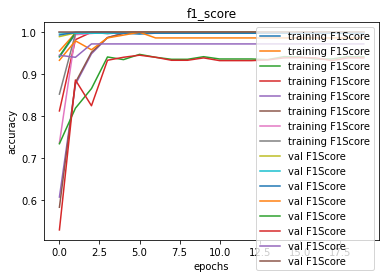

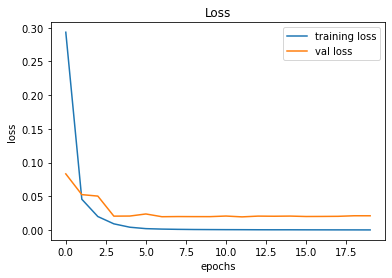

In [10]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
# model.save('./saved_models/Trafic_Signs_CNN_priority_signs(70x70).h5')

In [12]:
priority_signs_classes = {'0':12,
'1':13,
'2':14,
'3':43,
'4':44,
'5':45,
'6':46,
'7':47,}

In [18]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []

for c in range (12,15):
    for i in range(len(df.loc[df['ClassId'] == c]) ):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(priority_signs_classes[str(prediction[0])])
        
        if classid != priority_signs_classes[(str(prediction[0]))]:
             print(classid,priority_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 16ms/step
12 13 1 Test/04983.png
1/1 [==============================] - 0s 8ms/step
12 13 1 Test/03744.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/01489.png
1/1 [==============================] - 0s 15ms/step
12 13 1 Test/02258.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/11756.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/12214.png
1/1 [==============================] - 0s 11ms/step
12 44 4 Test/05934.png
1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 29ms/step
12 13 1 Test/01189.png
1/1 [==============================] - 0s 16ms/step
12 44 4 Test/06885.png
1/1 [==============================] - 0s 16ms/step
12 43 3 Test/08204.png
1/1 [==============================] - 0s 16ms/step
12 44 4 Test/10151.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 2ms/step
12 13 1 Test/05182.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/11543.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/04341.png
1/1 [==============================] - 0s 5ms/step
12 13 1 Test/03370.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/07273.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/09613.png
1/1 [==============================] - 0s 9ms/step
12 43 3 Test/10718.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/08308.png
1/1 [==============================] - 0s 9ms/step
12 43 3 Test/07857.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/00764.png
1/1 [==============================] - 0s 3ms/step
12 13 1 Test/02651.png
1/1 [==============================] - 0s 15ms/step
12 44 4 Test/00475.png
1/1 [==============================] - 0s 6ms/step
12 13 1 Test/02379.png
1/1 [==========================

1/1 [==============================] - 0s 4ms/step
12 13 1 Test/07279.png
1/1 [==============================] - 0s 16ms/step
12 43 3 Test/05872.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/10931.png
1/1 [==============================] - 0s 15ms/step
12 13 1 Test/01747.png
1/1 [==============================] - 0s 13ms/step
12 13 1 Test/03793.png
1/1 [==============================] - 0s 16ms/step
12 13 1 Test/05529.png
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
12 43 3 Test/03945.png
1/1 [==============================] - 0s 16ms/step
12 43 3 Test/12118.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 12ms/step


In [22]:
for c in range (43,48):
    for i in range(len(df.loc[df['ClassId'] == c]) ):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(priority_signs_classes[str(prediction[0])])
        
        if classid != priority_signs_classes[(str(prediction[0]))]:
             print(classid,priority_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 12ms/step
43 13 1 Test/43_1_30.png
1/1 [==============================] - 0s 15ms/step
43 44 4 Test/43_6_27.png
1/1 [==============================] - 0s 14ms/step
43 44 4 Test/43_2_19.png
1/1 [==============================] - 0s 13ms/step
43 44 4 Test/43_2_16.png
1/1 [==============================] - 0s 2ms/step
43 44 4 Test/43_1_19.png
1/1 [==============================] - 0s 8ms/step
43 44 4 Test/43_2_21.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
43 44 4 Test/43_6_21.png
1/1 [==============================] - 0s 16ms/step
44 45 5 Test/44_4_29.png
1/1 [==============================] - 0s 5ms/step
44 12 0 Test/44_4_24.png
1/1 [==============================] - 0s 16ms/step
44 45 5 Test/44_6_20.png
1/1 [==============================] - 0s 12ms/step
44 45 5 Test/44_7_28.png
1/1 [==============================] - 0s 15ms/step
44 12 0 Test/44_4_22.png
1/1 [==============================] - 0s 12ms/step
44 46 6 Test/44_6_16.png


1/1 [==============================] - 0s 6ms/step
44 46 6 Test/44_6_24.png
1/1 [==============================] - 0s 16ms/step
44 46 6 Test/44_2_19.png
1/1 [==============================] - 0s 15ms/step
44 45 5 Test/44_7_21.png
1/1 [==============================] - 0s 16ms/step
44 45 5 Test/44_7_27.png
1/1 [==============================] - 0s 14ms/step
44 45 5 Test/44_3_19.png
1/1 [==============================] - 0s 11ms/step
44 45 5 Test/44_4_18.png
1/1 [==============================] - 0s 16ms/step
44 45 5 Test/44_5_29.png
1/1 [==============================] - 0s 16ms/step
44 46 6 Test/44_5_20.png
1/1 [==============================] - 0s 7ms/step
44 45 5 Test/44_7_26.png
1/1 [==============================] - 0s 6ms/step
44 46 6 Test/44_1_11.png
1/1 [==============================] - 0s 17ms/step
44 46 6 Test/44_6_26.png
1/1 [==============================] - 0s 14ms/step
44 46 6 Test/44_6_29.png
1/1 [==============================] - 0s 3ms/step
44 12 0 Test/44_4_17.png
1/1

1/1 [==============================] - 0s 8ms/step
44 46 6 Test/44_4_25.png
1/1 [==============================] - 0s 4ms/step
44 45 5 Test/44_3_21.png
1/1 [==============================] - 0s 15ms/step
44 46 6 Test/44_2_21.png
1/1 [==============================] - 0s 9ms/step
44 12 0 Test/44_4_28.png
1/1 [==============================] - 0s 15ms/step
44 46 6 Test/44_4_27.png
1/1 [==============================] - 0s 5ms/step
44 12 0 Test/44_4_26.png
1/1 [==============================] - 0s 16ms/step
44 12 0 Test/44_4_14.png
1/1 [==============================] - 0s 0s/step
45 12 0 Test/45_4_29.png
1/1 [==============================] - 0s 16ms/step
45 44 4 Test/45_2_17.png
1/1 [==============================] - 0s 16ms/step
45 44 4 Test/45_6_20.png
1/1 [==============================] - 0s 16ms/step
45 44 4 Test/45_7_14.png
1/1 [==============================] - 0s 26ms/step
45 46 6 Test/45_6_13.png
1/1 [==============================] - 0s 3ms/step


1/1 [==============================] - 0s 7ms/step
45 44 4 Test/45_5_8.png
1/1 [==============================] - 0s 16ms/step
45 44 4 Test/45_2_16.png
1/1 [==============================] - 0s 18ms/step
45 44 4 Test/45_6_19.png
1/1 [==============================] - 0s 17ms/step
45 44 4 Test/45_3_36.png
1/1 [==============================] - 0s 6ms/step
45 44 4 Test/45_3_29.png
1/1 [==============================] - 0s 15ms/step
45 44 4 Test/45_5_9.png
1/1 [==============================] - 0s 16ms/step
45 44 4 Test/45_2_19.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
46 13 1 Test/46_2_17.png
1/1 [==============================] - 0s 16ms/step
46 13 1 Test/46_4_34.png
1/1 [==============================] - 0s 16ms/step
46 44 4 Test/46_1_21.png
1/1 [==============================] - 0s 5ms/step
46 13 1 Test/46_4_8.png
1/1 [==============================] - 0s 13ms/step
46 13 1 Test/46_4_19.png
1/1 [==============================] - 0s 20ms/step
46 13 1 Test/46_4_13.png
1/1 [==============================] - 0s 16ms/step
46 13 1 Test/46_1_5.png
1/1 [==============================] - 0s 17ms/step
46 44 4 Test/46_3_29.png
1/1 [==============================] - 0s 16ms/step
46 13 1 Test/46_1_18.png
1/1 [==============================] - 0s 2ms/step
46 13 1 Test/46_4_32.png
1/1 [==============================] - 0s 12ms/step
46 13 1 Test/46_4_3.png
1/1 [==============================] - 0s 15ms/step
46 44 4 Test/46_3_2.png
1/1 [==============================] - 0s 16ms/step
46 13 1 Test/46_1_14.png
1/1 [

1/1 [==============================] - 0s 8ms/step
46 13 1 Test/46_4_38.png
1/1 [==============================] - 0s 9ms/step
46 13 1 Test/46_4_6.png
1/1 [==============================] - 0s 16ms/step
46 45 5 Test/46_1_22.png
1/1 [==============================] - 0s 15ms/step
46 13 1 Test/46_6_16.png
1/1 [==============================] - 0s 14ms/step
46 13 1 Test/46_1_11.png
1/1 [==============================] - 0s 5ms/step
46 13 1 Test/46_4_29.png
1/1 [==============================] - 0s 8ms/step
46 13 1 Test/46_4_30.png
1/1 [==============================] - 0s 4ms/step
46 13 1 Test/46_4_4.png
1/1 [==============================] - 0s 15ms/step
46 13 1 Test/46_4_37.png
1/1 [==============================] - 0s 15ms/step
46 44 4 Test/46_3_30.png
1/1 [==============================] - 0s 15ms/step
46 13 1 Test/46_4_33.png
1/1 [==============================] - 0s 16ms/step
46 13 1 Test/46_4_36.png
1/1 [==============================] - 0s 14ms/step
46 13 1 Test/46_2_19.png
1/1 [=

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


In [23]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.9560029960511638


Text(0.5, 0.98, 'Plot of confusion matrix')

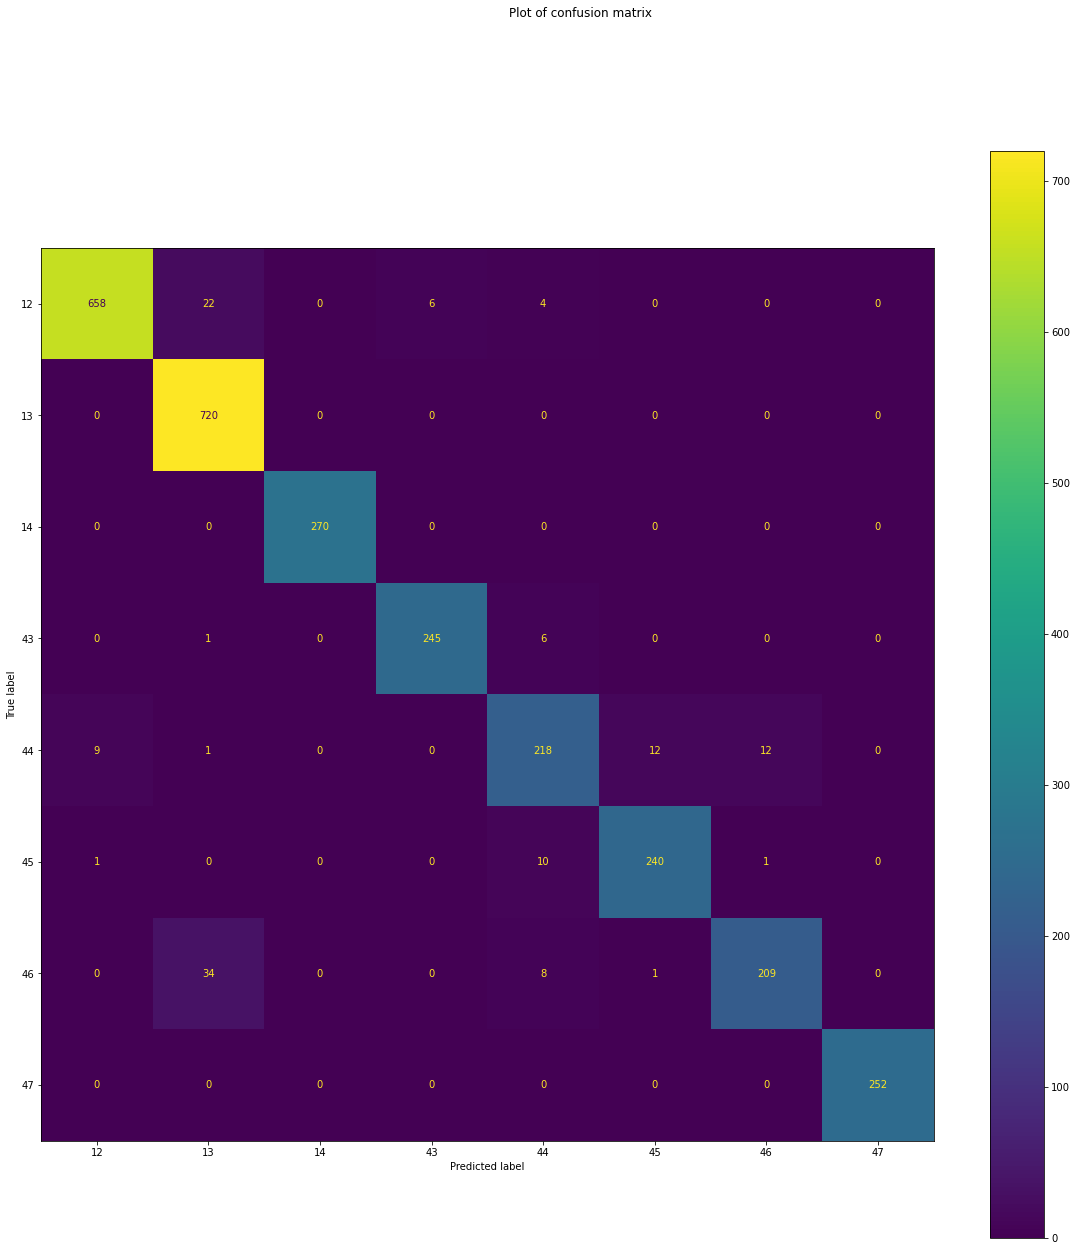

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')